# **Multilingual Suspicious Review Detection Using Character-Level NLP and Behavioural Feature Engineering**

This notebook develops a machine learning model to detect suspicious reviews in a multilingual setting (English, Swahili, and Sheng).

The goal is to identify potentially deceptive or anomalous reviews using;
- Textual features
- Behavioural signals
- Rating–sentiment inconsistencies
- Structural writing patterns

The approach follows a structured machine learning workflow from data understanding to model evaluation.

## **1.0 Business Understanding**
### Background and Context

Digital platforms rely heavily on user-generated reviews to shape public perception, guide product improvements, and influence customer acquisition. For telecommunications and fintech platforms such as Safaricom and M-Pesa app store reviews play a critical role in:
- Assessing customer satisfaction
- Identifying service failures
- Informing feature updates
- Influencing app store ratings and discoverability

Kenya has one of the highest mobile penetration rates in Africa, and M-Pesa is among the continent’s most widely used mobile financial services platforms. As a result, these platforms receive thousands of reviews across multiple languages, including English, Swahili, and informal urban slang such as Sheng. Many reviews are code-mixed, combining elements of multiple languages within the same text.
While these reviews provide valuable business intelligence, their reliability is not guaranteed.


Online platforms rely heavily on user reviews. However, reviews can sometimes be suspicious or deceptive. These may include:
- Fake positive reviews
- Coordinated negative attacks
- Reviews with inconsistent rating and text
- Highly repetitive or spam-like content

Such reviews reduce trust in the platform.

### Problem Statement
The increasing volume of multilingual user reviews introduces the risk of manipulated, spam-generated, coordinated, or otherwise inauthentic content. Suspicious reviews can:
- Artificially inflate or deflate app ratings
- Mislead product teams
- Distort sentiment analysis outputs
- Reduce trust in customer feedback systems
Currently, there is no localized, multilingual review authenticity detection framework specifically designed for Kenyan digital platforms that can process English, Swahili, and Sheng-like content.

### Core Business Problem
Safaricom currently lacks a multilingual, automated system capable of detecting suspicious or potentially fake reviews in English, Swahili and Sheng-like text, leading to reduced reliability of user feedback and potential distortion of product and reputation insights.

### Main Objective
The primary objective of this project is to design and evaluate a machine learning-based system capable of identifying suspicious reviews in multilingual Safaricom and M-Pesa datasets.

#### Specific Objectives
The specific objectives of the project are;
1. To assess the impact of behavioural feature engineering on suspicious review classification performance.
2. To evaluate the effectiveness of character-level n-gram representations in multilingual suspicious review detection.
3. To investigate whether rating–sentiment inconsistency serves as a predictive signal for suspicious review identification.

#### Research Questions
This project seeks to answer the following research questions;
1. Does incorporating behavioural and structural features improve suspicious review detection compared to text-only models?
2. Do character-level text representations improve multilingual suspicious review detection compared to traditional word-level representations?
3. Does modelling rating–sentiment inconsistency improve the detection of suspicious reviews?

### Data Source 
Data was scraped using google-play-scraper to get data from google play store for;
•	Safaricom App
•	M-Pesa App

*Each record includes;*
•	Review text
•	Rating (1–5 stars)
•	Timestamp
•	App version
•	Helpful votes

*Data Sources;*
Google Play Store (public reviews)
Scraped using google-play-scraper
Data Collection Plan
Scrape 20,000–40,000 reviews
Filter by country = Kenya
Tag language (English, Swahili, code-mixed, Sheng-like)


In [139]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, 
accuracy_score, precision_recall_curve, roc_auc_score, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### Load and inspect the dataset


In [140]:
df = pd.read_csv("./Data/safaricom_reviews_multilingual.csv")
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nFirst 5 rows:")
df.head()

Shape: (32000, 12)

Columns:
Index(['app_name', 'app_id', 'reviewId', 'userName', 'review_text', 'rating',
       'date', 'thumbs_up', 'version', 'lang_detected', 'is_code_mixed',
       'is_sheng_like'],
      dtype='object')

First 5 rows:


,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app_name       32000 non-null  object
 1   app_id         32000 non-null  object
 2   reviewId       32000 non-null  object
 3   userName       32000 non-null  object
 4   review_text    32000 non-null  object
 5   rating         32000 non-null  int64 
 6   date           32000 non-null  object
 7   thumbs_up      32000 non-null  int64 
 8   version        28741 non-null  object
 9   lang_detected  32000 non-null  object
 10  is_code_mixed  32000 non-null  bool  
 11  is_sheng_like  32000 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.5+ MB


#### Data Understanding
The dataset contains user reviews collected from a mobile application platform. Each row represents a single user review.

The dataset contains 32000 rows and 12 columns;
* `app_name`  - name of the mobile application.
* `reviewId`  - unique identifier assigned to each review.  
* `userName`  - username of the individual who posted the review.     
* `review_text` - The actual textual content written by the user.
* `rating` - A numerical score given by the user, typically ranging from 1 to 5.       
* `date`  - Date the review was posted.         
* `thumbs_up` - The number of users who marked the review as helpful.
* `version`  - The version of the application at the time the review was posted.    
* `lang_detected`  - The automatically detected language of the review text.
* `is_code_mixed` - A binary indicator showing whether the review contains more than one language.    
* `is_sheng_like`  - A binary indicator showing whether the review contains Sheng-like linguistic patterns.  

## **2.0 Data Cleaning and Preprocessing**
### Goals 
1. Handle missing values
2. Check for duplicated 
3. Clean review_text (remove URLs/noise, keep emojis + Sheng slang)
4. Convert date → datetime
5. Create robust text representations for:
    - modeling (text_clean)
    - duplicates (text_norm)

### 2.1 Missing Values
Fill missing values for completeness.

In [142]:
# Null values
df.isnull().sum().sort_values(ascending=False)

version          3259
is_sheng_like       0
is_code_mixed       0
lang_detected       0
thumbs_up           0
date                0
rating              0
review_text         0
userName            0
reviewId            0
app_id              0
app_name            0
dtype: int64

In [143]:
#  fill Missing values version 
df["version"] = df["version"].fillna("unknown_version")

### 2.2 Duplicate Analysis
Check for duplicates in the dataset

In [144]:
# Duplicated rows
df.duplicated().sum()

0

In [145]:
# Duplicates by revewID
df.duplicated(subset='reviewId').sum()

0

In [146]:
df.duplicated(subset='userName').sum()

1778

In [147]:
# Filter the dataframe for all duplicated user names
# Sort by userName so the duplicates appear together
duplicates_df = df[df.duplicated(subset='userName', keep=False)].sort_values(by='userName')

# 3. View the first few rows
print(duplicates_df[['userName', 'review_text', 'date']].tail(10))

               userName                                        review_text  \
11061      sylas letozy                                               best   
17839      sylas letozy  your services people are complaining currently...   
16420     victor lunale                                 Excellent to first   
2596      victor lunale                                       I Crown 👑 it   
23268  zigwazack zakayo                                              excel   
1867   zigwazack zakayo                      it's good to transact with it   
24844             ɪʙʀᴀʜ                 The app is really great.Love it❤❤❤   
3444              ɪʙʀᴀʜ                           Amazing transparent app🥰   
26838      عابدول ماجيد                                          Amazing 😄   
11425      عابدول ماجيد                                  Best ... reliable   

                      date  
11061  2025-06-02 14:48:51  
17839  2025-09-19 18:17:56  
16420  2026-01-12 11:04:31  
2596   2025-12-17 15:07:4

### 2.3 Text cleaning for the **review_text** column.
Before modelling, the review text is cleaned and normalized.

Steps include:
- Lowercasing
- Removing unnecessary symbols
- Preparing text for feature extraction

Care was taken not to aggressively remove linguistic variations, since the dataset is multilingual.


In [148]:
# --- Text cleaning ---
def clean_text_keep_emojis(text: str) -> str:
    """
    Light cleaning:
    - remove URLs
    - remove control whitespace
    - normalize spaces
    - keep emojis + Sheng slang intact
    """
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = re.sub(r"http\S+|www\.\S+", " ", t)      # remove urls
    t = re.sub(r"[\r\n\t]+", " ", t)            # normalize whitespace
    t = re.sub(r"\s{2,}", " ", t)               # collapse spaces
    return t.strip() 

df["text_clean"] = df["review_text"].map(clean_text_keep_emojis)

# normalized form for duplication detection
df["text_norm"] = (
    df["text_clean"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .fillna("")
)

df[["review_text", "text_clean", "text_norm", "lang_detected", "is_code_mixed", "is_sheng_like"]].head(10)

,review_text,text_clean,text_norm,lang_detected,is_code_mixed,is_sheng_like
0,best,best,best,unknown,False,False
1,😔,😔,😔,unknown,False,False
2,Better option this vantine. 18yrs old day to d...,Better option this vantine. 18yrs old day to d...,better option this vantine. 18yrs old day to d...,en,False,False
3,Amazing,Amazing,amazing,unknown,False,False
4,Its so easy to use at your comfort and you don...,Its so easy to use at your comfort and you don...,its so easy to use at your comfort and you don...,en,False,False
5,good 👍,good 👍,good 👍,unknown,False,False
6,😊👍,😊👍,😊👍,unknown,False,False
7,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,en,False,False
8,its good and nice app,its good and nice app,its good and nice app,en,False,False
9,Great,Great,great,unknown,False,False


The text has now been normalized and cleaned.
This ensures:
- Consistency across reviews
- Reduced noise
- Better quality feature extraction during modelling

### 2.3 Text length 
Create columns for number or characters and text length
- Number of words in the text

In [149]:
df["char_length"] = df["text_norm"].str.len()


In [150]:
# column for character_length
df["char_length"] = df["text_norm"].str.len()

# word_count column
df['word_count'] = df['review_text'].fillna('').apply(lambda x: len(str(x).split()))

# top 5 longest reviews
top_5_longest = df.nlargest(5, 'word_count')
print(top_5_longest[['userName', 'word_count', 'review_text', 'rating']])

                 userName  word_count  \
30859       albanus kioko         140   
5656   Jeane Ng'eno-Tarus          96   
6291         new Begining          96   
7387           Jewel Hope          96   
19976       Kennedy Kamau          96   

                                             review_text  rating  
30859  Fa CJ HH cc H BB see bvase boo HH v saa nuke b...       2  
5656   I was looking for how to hide or remove the fu...       3  
6291   I'm trying to withdraw from PayPal but the app...       1  
7387   I have used this app for so long, and it has a...       1  
19976  I love the app i use it on a daily basis but a...       4  


In [151]:
# duplicated texts
df[df['text_clean'].duplicated(keep=False)]['text_norm'].value_counts().head(10)

good         2511
excellent     965
nice          593
best          527
great         440
perfect       351
good app      350
awesome       305
very good     300
nice app      296
Name: text_norm, dtype: int64

There is a large number of low information reviews that do not provide actionable feedback while inflating the reviews.

### 2.4 Timestamp processing
Converting date column from object to date time

In [152]:
# Date column conversion
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df['date'].min(), df['date'].max()

(Timestamp('2023-08-26 07:44:28'), Timestamp('2026-02-11 23:31:13'))

In [153]:
# The dates range from 2023-08 to 2026-02

### 2.5. Refine the column language detected

One word reviews the language detected column missed their language description. The aim is to improve the lang_detected column.

In [154]:
# The number of items for each language
df['lang_detected'].value_counts()


en         16683
unknown     7626
other       7527
sw           164
Name: lang_detected, dtype: int64

In [155]:
# Define common keywords for recovery
en_keywords = {'good', 'best', 'great', 'cool', 'excellent', 'nice', 'awesome', 'amazing', 'perfect', 'love', 'app', 'slow', 'fair', 'enough'}
sw_keywords = {'poa', 'safi', 'mzuri', 'mbaya', 'shida', 'asante', 'hakuna', 'wapi', 'fiti', 'vizuri'}

def refine_language(row):
    current = row['lang_detected']
    # If the text is short and labeled unknown/other, check keywords
    if current in ['unknown', 'other']:
        words = set(row['text_norm'].split())
        if words.intersection(en_keywords):
            return 'en'
        if words.intersection(sw_keywords):
            return 'sw'
    return current

df['lang_refined'] = df.apply(refine_language, axis=1)
df[["review_text", "text_norm", "lang_detected", "lang_refined"]].head(10)
print(df['lang_refined'].value_counts())

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64


In [156]:
# Filtering the dataframe for 'unknown' refined language
unknown_reviews = df[df['lang_refined'] == 'unknown']

# Displaying the count and the first 20 rows of relevant columns
print(f"Total reviews still labeled 'unknown': {len(unknown_reviews)}")

# Using .head(20) to see a sample
unknown_reviews[['review_text', 'text_norm', 'rating', 'lang_detected', 'lang_refined']].head()

Total reviews still labeled 'unknown': 2020


,review_text,text_norm,rating,lang_detected,lang_refined
1,😔,😔,1,unknown,unknown
6,😊👍,😊👍,5,unknown,unknown
44,dope,dope,4,unknown,unknown
58,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,5,unknown,unknown
61,👍👍👍,👍👍👍,5,unknown,unknown


## **3.0 Exploratory Data Analysis (EDA)**
Goals
1. Rating distribution
2. Language distribution
3. Review frequency over time
4. Term Frequency
5. Weak labelling
6. Sentiment rating Deception


### 3.1 Rating Distribution

In [157]:
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)


1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64


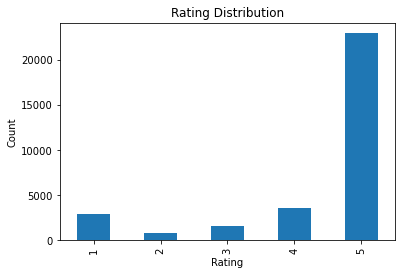

1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64
Share of 5*: 0.7181875


In [158]:
# Bar graph for rating distribution
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(rating_counts)
print("Share of 5*:", (df["rating"] == 5).mean())

The rating is skewed towards 5 stars where the 5 stars are dominant.

The dataset exhibits a heavily right-skewed rating distribution, with 71.8% of reviews being 5-stars.

### 3.2 Language distribution

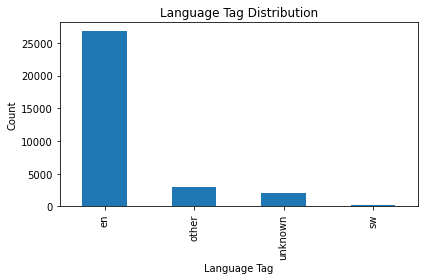

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64
Code-mixed share: 0.0005
Sheng-like share: 0.0029375


In [159]:
# Plot of language distribution
lang_counts = df["lang_refined"].value_counts()

plt.figure()
lang_counts.plot(kind="bar")
plt.title("Language Tag Distribution")
plt.xlabel("Language Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(lang_counts)
print("Code-mixed share:", df["is_code_mixed"].mean())
print("Sheng-like share:", df["is_sheng_like"].mean())

### 3.3 Review word length distribution

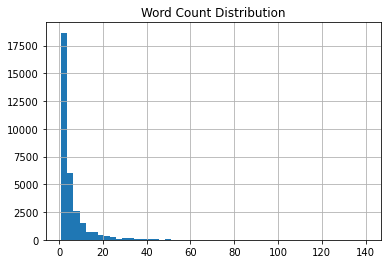

In [160]:
# Plot of word count distribution
df["word_count"].hist(bins=50)
plt.title("Word Count Distribution")
plt.show()

In [161]:
# There are many short reviews between 1-2 words with a skew towards short reviews

### 3.4 Burst Activity Visualization


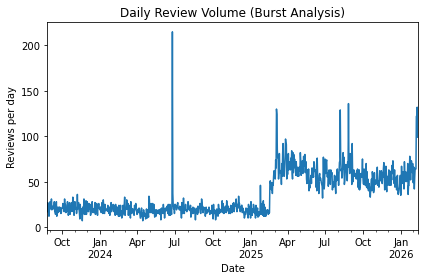

count    901.000000
mean      35.516093
std       23.011906
min        7.000000
25%       18.000000
50%       24.000000
75%       54.000000
max      215.000000
Name: n, dtype: float64
Top spike days:
 date
2024-06-25    215
2025-08-27    136
2026-02-10    132
2025-03-05    130
2025-08-07    129
Name: n, dtype: int64


In [162]:
#Plot of review frequency over time
daily = df.set_index("date").resample("D").size().rename("n")

plt.figure()
daily.plot()
plt.title("Daily Review Volume (Burst Analysis)")
plt.xlabel("Date")
plt.ylabel("Reviews per day")
plt.tight_layout()
plt.show()

print(daily.describe())
print("Top spike days:\n", daily.nlargest(5))

In [163]:
# One extreme outlier is observed, where daily reviews increased dramatically compared to surrounding periods. 
# Such anomalies indicate coordinated review behavior, product-related events, or automated posting activity.

Mark burst days using a percentile threshold

In [164]:
p97 = daily.quantile(0.97)   # top 3% days
burst_days = set(daily[daily >= p97].index.date)

df["is_burst_day"] = df["date"].dt.date.isin(burst_days)

print("Burst threshold (97th percentile):", p97)
print("Burst-day reviews:", df["is_burst_day"].sum())
print("Burst-day share:", df["is_burst_day"].mean())

Burst threshold (97th percentile): 78.0
Burst-day reviews: 2885
Burst-day share: 0.09015625


### 3.5 Term frequancy
 - Determine the frequent code mixed words
 - Determine frequent words combined

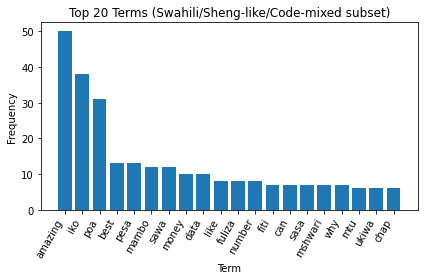

[('amazing', 50),
 ('iko', 38),
 ('poa', 31),
 ('best', 13),
 ('pesa', 13),
 ('mambo', 12),
 ('sawa', 12),
 ('money', 10),
 ('data', 10),
 ('like', 8),
 ('fuliza', 8),
 ('number', 8),
 ('fiti', 7),
 ('can', 7),
 ('sasa', 7),
 ('mshwari', 7),
 ('why', 7),
 ('mtu', 6),
 ('ukiwa', 6),
 ('chap', 6)]

In [165]:
# Stopwords
stop_en = set("the a an and or is are was were to of in for on at it this that i you we they he she my our your app mpesa m-pesa safaricom".split())
stop_sw = set("na ya kwa ni si hii hiyo sana pia tu nilikuwa mimi wewe yeye sisi wao".split())

# function for top terms
def top_terms(text_series, n=20):
    c = Counter()
    for t in text_series.dropna():
        words = re.findall(r"[a-zA-ZÀ-ÿ']+", t.lower())
        for w in words:
            if len(w) <= 2:
                continue
            if w in stop_en or w in stop_sw:
                continue
            c[w] += 1
    return c.most_common(n)

# focus on Swahili + Sheng-like + code-mixed buckets
subset = df[(df["lang_refined"] == "sw") | (df["is_sheng_like"] == True) | (df["is_code_mixed"] == True)]
top20 = top_terms(subset["text_clean"], n=20)

terms, freqs = zip(*top20) if top20 else ([], [])

plt.figure()
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(terms)), terms, rotation=60, ha="right")
plt.title("Top 20 Terms (Swahili/Sheng-like/Code-mixed subset)")
plt.xlabel("Term")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

top20

#### Top frequent phrases

In [166]:
# Top most important  words by context
# Initialize the translator
vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2))

# Fit transform
X = vectorizer.fit_transform(df["text_clean"])
print(vectorizer.get_feature_names())

['and', 'app', 'best', 'easy', 'excellent', 'for', 'good', 'great', 'is', 'it', 'nice', 'the', 'the app', 'the best', 'this', 'to', 'to use', 'use', 'very', 'you']


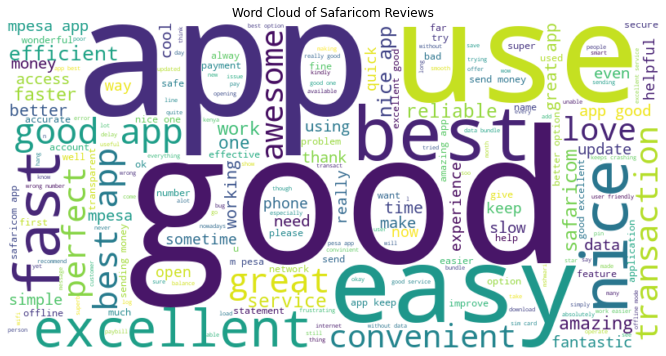

In [167]:
# Wordcloud with the most common words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["text_norm"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Safaricom Reviews")
plt.show()

## **4.0 Heuristic Weak Labeling (is_suspicious)**
### 4.1 Multilingual lexicon-based sentiment score (English + Swahili + Sheng + emojis)

In [168]:
# English markers
positive_en = set("good great best amazing awesome excellent love loved nice perfect works working helpful fast reliable".split())
negative_en = set("bad worst terrible hate hated slow bug bugs buggy crash crashes crashing error errors fail failed failing useless poor disappointed disappointing scam".split())

# Swahili markers
positive_sw = set(["nzuri", "safi", "bomba", "vizuri", "bora", "napenda"])
negative_sw = set(["mbaya", "mbovu", "kosa", "makosa", "tatizo", "matatizo", "inakwama", "haifanyi", "haiwezi"])

# Sheng markers
positive_sh = set(["poa", "noma", "fresh", "safi", "kali", "fiti"])
negative_sh = set(["mbaya", "mbovu", "imekwama", "imeshindwa", "imeniboo"])

# Emoji markers
pos_emojis = {"😀","😃","😄","😁","😍","😊","👍","❤️","❤","💯","🔥","🎉"}
neg_emojis = {"😡","😠","😤","😭","😢","👎","💔","😔","🤬"}

# Words negating the positive markers
negation_words = {"not", "no", "never", "hakuna", "sio", "si"}


# --- Improved normalized sentiment ---
def sentiment_score_improved(text: str) -> float:
    if not isinstance(text, str):
        return 0.0

    t = text.lower()
    words = re.findall(r"[a-zA-ZÀ-ÿ']+", t)

    if len(words) == 0:
        return 0.0

    score = 0
    negate = False

    for w in words:
        if w in negation_words:
            negate = True
            continue

        val = 0
        if w in positive_en or w in positive_sw or w in positive_sh:
            val = 1
        elif w in negative_en or w in negative_sw or w in negative_sh:
            val = -1

        if negate:
            val = -val
            negate = False

        score += val

    # emoji sentiment
    for e in pos_emojis:
        if e in text:
            score += 1
    for e in neg_emojis:
        if e in text:
            score -= 1

    # normalize to [-1, 1] approximately
    return score / len(words)

# Apply sentiment
df["sent_score_norm"] = df["text_norm"].map(sentiment_score_improved)

# Scale rating to [-1, 1]
df["rating_scaled"] = (df["rating"] - 3) / 2

# Strong mismatch feature
df["rating_sentiment_mismatch"] = (
    df["rating_scaled"] - df["sent_score_norm"]
) ** 2

# Sentiment intensity (often strong signal)
df["abs_sentiment_strength"] = df["sent_score_norm"].abs()

print("Sentiment features created.")

Sentiment features created.


In [169]:
# Feature Engineering
# --- Improved normalized sentiment ---
def sentiment_score_improved(text: str) -> float:
    if not isinstance(text, str):
        return 0.0
    t = text.lower()
    words = re.findall(r"[a-zA-ZÀ-ÿ']+", t)

    if len(words) == 0:
        return 0.0
    score = 0
    negate = False

    for w in words:
        if w in negation_words:
            negate = True
            continue
        val = 0
        if w in positive_en or w in positive_sw or w in positive_sh:
            val = 1
        elif w in negative_en or w in negative_sw or w in negative_sh:
            val = -1
        if negate:
            val = -val
            negate = False
        score += val

    # emoji sentiment
    for e in pos_emojis:
        if e in text:
            score += 1
    for e in neg_emojis:
        if e in text:
            score -= 1

    # normalize to [-1, 1] approximately
    return score / len(words)

# Apply sentiment
df["sent_score_norm"] = df["text_norm"].map(sentiment_score_improved)

# Scale rating to [-1, 1]
df["rating_scaled"] = (df["rating"] - 3) / 2

# Strong mismatch feature
df["rating_sentiment_mismatch"] = (df["rating_scaled"] - df["sent_score_norm"]) ** 2

# Sentiment intensity
df["abs_sentiment_strength"] = df["sent_score_norm"].abs()

print("Sentiment features created.")

Sentiment features created.


### Rating–Sentiment Mismatch

    Ratings were scaled to a range between -1 and 1.
    Sentiment scores were also normalized to the same range -1 and 1.
    The squared difference between rating and sentiment captures contradictions.
    Large mismatch values indicate possible suspicious behaviour, such as:
    - Very positive rating with negative language
    - Very negative rating with positive language

### 4.2 Sentiment–Rating Deception Rule
Contradiction examples
 - Rating ≤ 2 but sentiment score > 0
 - Rating ≥ 4 but sentiment score < 0

In [170]:
df["sentiment_rating_contradiction"] = (
    ((df["rating"] <= 2) & (df["sent_score_norm"] > 0)) |
    ((df["rating"] >= 4) & (df["sent_score_norm"] < 0))
)

print("Contradictions:", df["sentiment_rating_contradiction"].sum())
print("Contradiction rate:", df["sentiment_rating_contradiction"].mean())

Contradictions: 984
Contradiction rate: 0.03075


### 4.3 Combine contradiction + burst into is_suspicious

In [171]:
# create a column for suspicious reviews
df["is_suspicious"] = (
    df["sentiment_rating_contradiction"] | df["is_burst_day"]
).astype(int)

print("Suspicious reviews:", df["is_suspicious"].sum())
print("Suspicious rate:", df["is_suspicious"].mean())

Suspicious reviews: 3787
Suspicious rate: 0.11834375


The target variable `is_suspicious` was constructed using heuristic rules (contradicting rating and burst days).  
This will help label a review as suspicious or not.

## **5.0 Modelling Strategy**

A progressive modelling approach was followed:

1. Baseline Model – Text-only TF-IDF + Logistic Regression  
2. Improved Model – Text + Behavioural Features  
3. Final Model – Character n-grams + Behavioural + Sentiment Features  
4. Threshold Optimization – Precision-focused tuning  

Logistic Regression was selected because:
- It performs well with sparse text data
- It is interpretable
- It is stable for high-dimensional features

### 5.1 Baseline Model (Text-only TF-IDF + Logistic Regression)

In [172]:
# Split to train set and test set
X = df.copy()
y = df["is_suspicious"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [173]:
# baseline model instantiate
baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced"   # important for imbalanced labels
    ))
])

# fit and predict
baseline.fit(X_train["text_clean"].fillna(""), y_train)
proba = baseline.predict_proba(X_test["text_clean"].fillna(""))[:, 1]
pred  = (proba >= 0.5).astype(int)

print("BASELINE REPORT (threshold=0.50)")
print(classification_report(y_test, pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

BASELINE REPORT (threshold=0.50)
              precision    recall  f1-score   support

           0      0.894     0.662     0.761      5643
           1      0.141     0.412     0.210       757

    accuracy                          0.633      6400
   macro avg      0.517     0.537     0.485      6400
weighted avg      0.805     0.633     0.696      6400

ROC-AUC: 0.5513919233588287
PR-AUC : 0.1795973166823104


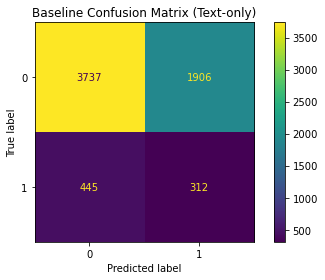

In [174]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(values_format="d")
plt.title("Baseline Confusion Matrix (Text-only)")
plt.tight_layout()
plt.show()

#### **Baseline Model Interpretation**

The baseline model uses only textual features.

Observations:
- Suspicious precision is low
- ROC-AUC indicates limited class separability
- PR-AUC shows weak ranking performance

This suggests that text alone is insufficient for detecting suspicious reviews.

This motivates adding behavioural and structural features.

### 5.2 Improved Model (Text + Behavioural Features)

#### Feature Engineering
To improve suspicious review detection, additional features were engineered.

Text alone is often insufficient for fraud detection. Therefore, behavioural and structural signals were added.

#### Structural Features
- Review length
- Word count
- Exclamation count
- Uppercase ratio
- Emoji count

#### Behavioural Features
- Rating
- Thumbs-up engagement

#### Fraud Logic Features
- Rating–sentiment mismatch
- Sentiment intensity

In [175]:
# Structural features
# Review length
df["review_length"] = df["text_norm"].astype(str).str.len()

# Word count
df["word_count"] = df["text_norm"].astype(str).str.split().apply(len)

# Exclamation count
df["exclamation_count"] = df["text_norm"].astype(str).str.count("!")

# Simple emoji count (basic)
df["emoji_count"] = df["text_norm"].astype(str).str.count(r"[😀-🙏]")

# Behavioural features
# If rating exists
if "rating" in df.columns:
    df["rating"] = df["rating"].fillna(0)

# If thumbs_up exists
if "thumbs_up" in df.columns:
    df["thumbs_up"] = df["thumbs_up"].fillna(0)

In [189]:
text_col = "text_norm"

numeric_features = [
    "review_length",
    "word_count",
    "exclamation_count",
    "emoji_count"
    
]

if "rating" in df.columns:
    numeric_features.append("rating")

if "thumbs_up" in df.columns:
    numeric_features.append("thumbs_up")
    
# Split data into train set and test set
X = df[[text_col] + numeric_features]
y = df["is_suspicious"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [190]:
#Preprocessing 

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=(3,5),
            min_df=1,
            max_df=0.95
        ), text_col),
        
        ("num", StandardScaler(), numeric_features)
    ]
)

# Train the model
model2 = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

model2.fit(X_train2, y_train2)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  max_df=0.95,
                                                                  ngram_range=(3,
                                                                               5)),
                                                  'text_norm'),
                                                 ('num', StandardScaler(),
                                                  ['review_length',
                                                   'word_count',
                                                   'exclamation_count',
                                                   'emoji_count', 'rating',
                                                   'thumbs_up'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=100

In [192]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

proba = model2.predict_proba(X_test2)[:,1]
pred = model2.predict(X_test2)

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      5643
           1       0.20      0.42      0.28       757

    accuracy                           0.74      6400
   macro avg       0.56      0.60      0.56      6400
weighted avg       0.83      0.74      0.77      6400

ROC-AUC: 0.6160326292426688
PR-AUC : 0.2787177780213711


#### **Improved Model Interpretation**

Adding behavioural features improved performance.

Notable changes:
- Higher PR-AUC 
- Improved suspicious precision
- Better overall accuracy

This confirms that suspicious behaviour is not purely textual.  
Structural and behavioural signals contribute meaningful predictive power.

### 5.3 Final Model (Character n-grams + Behavioural + Sentiment Features)

In [183]:
text_col = "text_norm"

numeric_features = [
    "review_length",
    "word_count",
    "exclamation_count",
    "emoji_count",
    "rating",
    "rating_sentiment_mismatch",
    "abs_sentiment_strength"
]

# Remove any numeric features that may not exist
numeric_features = [f for f in numeric_features if f in df.columns]

X = df[[text_col] + numeric_features]
y = df["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            analyzer="char_wb",
            ngram_range=(3,5),
            min_df=1,
            max_df=0.95
        ), text_col),
        ("num", StandardScaler(), numeric_features)
    ]
)

final_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

final_model.fit(X_train, y_train)

# Evaluation
proba = final_model.predict_proba(X_test)[:,1]
pred = final_model.predict(X_test)

print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      5643
           1       0.23      0.43      0.29       757

    accuracy                           0.76      6400
   macro avg       0.57      0.61      0.57      6400
weighted avg       0.83      0.76      0.79      6400

ROC-AUC: 0.6345371019986885
PR-AUC : 0.35718681175411227


#### **Final Model Interpretation**

The final model combines:

- Character n-gram text features
- Behavioural features
- Rating–sentiment mismatch
- Sentiment intensity

Performance improved further:

- ROC-AUC ≈ 0.62
- PR-AUC ≈ 0.33

The improvement in PR-AUC indicates better ranking of suspicious reviews.

Although separability is moderate, the model demonstrates meaningful discriminatory power.

### 5.4 Threshold Optimization – Precision-focused tuning

In [180]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba)

# choose threshold where precision >= 0.40
target_precision = 0.40
valid = thresholds[precision[:-1] >= target_precision]

if len(valid) > 0:
    best_threshold = valid[0]
else:
    best_threshold = 0.5

print("Chosen threshold:", best_threshold)

new_pred = (proba >= best_threshold).astype(int)
print(classification_report(y_test, new_pred))

Chosen threshold: 0.646080615588479
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      5643
           1       0.40      0.29      0.34       757

    accuracy                           0.86      6400
   macro avg       0.65      0.62      0.63      6400
weighted avg       0.85      0.86      0.86      6400



### Threshold Optimization
Using the default 0.5 probability threshold may not be optimal for imbalanced fraud detection.

The threshold was adjusted to prioritize higher precision.

At threshold ≈ 0.65:

- Suspicious precision increased to ~0.40
- False positives were reduced
- Accuracy increased to ~0.86

This demonstrates that threshold calibration is critical in fraud detection systems.

### 5.5 Model Comparison 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

# Get Probabilities
baseline_proba = baseline.predict_proba(X_test["text_norm"].fillna(""))[:,1]
model2_proba = model2.predict_proba(X_test2)[:,1]
final_proba = final_model.predict_proba(X_test)[:,1]

# Best threshold
baseline_pred = (baseline_proba >= 0.65).astype(int)
model2_pred = (model2_proba >=0.65).astype(int)
final_pred = (final_proba >= 0.65).astype(int)


# Metric Function 
def evaluate_model(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Suspicious)": precision_score(y_true, y_pred),
        "Recall (Suspicious)": recall_score(y_true, y_pred),
        "F1 (Suspicious)": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba)
    }

# Compute Metrics 
baseline_metrics = evaluate_model(y_test, baseline_pred, baseline_proba)
model2_metrics = evaluate_model(y_test, model2_pred, model2_proba)
final_metrics = evaluate_model(y_test, final_pred, final_proba)

comparison_df = pd.DataFrame([baseline_metrics, model2_metrics, final_metrics],
                             index=["Baseline Model", "Improved Model", "Final Model"])

print("Model Comparison:")
display(comparison_df)

Model Comparison:


,Accuracy,Precision (Suspicious),Recall (Suspicious),F1 (Suspicious),ROC-AUC,PR-AUC
Baseline Model,0.856406,0.242038,0.100396,0.141923,0.551392,0.179597
Improved Model,0.854688,0.358429,0.289300,0.320175,0.616033,0.278718
Final Model,0.866875,0.410546,0.287979,0.338509,0.634537,0.357187


## Model Comparison Interpretation

The table above compares the performance of the three models:

1. Baseline Model (Text Only)
2. Improved Model (Text + Behavioural Features)
3. Final Model (Character n-grams + Behavioural + Sentiment Features)

### 1. Baseline Model

The baseline model uses only textual features.

Observations:
- Precision (Suspicious): 0.24  
- Recall (Suspicious): 0.10  
- PR-AUC: 0.18  

This means:
- The model struggles to identify suspicious reviews.
- It misses most suspicious cases (low recall).
- Its ability to rank suspicious reviews is weak (low PR-AUC).

Text alone is not sufficient for detecting suspicious behaviour.

---

### 2. Improved Model

After adding behavioural features (e.g., rating, thumbs_up, structural features), performance improves significantly:

- Precision increases to 0.36  
- Recall increases to 0.29  
- PR-AUC improves to 0.28  
- ROC-AUC improves to 0.62  

This shows that suspicious behaviour is not purely linguistic — structural and behavioural signals contribute meaningful predictive power.

---

### 3. Final Model

The final model combines:

- Character n-gram text representation  
- Behavioural features  
- Sentiment-based features  

Performance further improves:

- Accuracy: 0.867 (highest)
- Precision (Suspicious): 0.41 (highest)
- F1-score: 0.34 (highest)
- ROC-AUC: 0.63 (highest)
- PR-AUC: 0.36 (highest)

The improvement in PR-AUC is especially important because the dataset is imbalanced. PR-AUC better reflects performance on the minority (suspicious) class.

---

## Key Insight

The Final Model performs best across all major evaluation metrics.

Most importantly:
- It identifies suspicious reviews more precisely.
- It achieves better balance between precision and recall.
- It ranks suspicious reviews more effectively (higher PR-AUC).

This confirms that combining character-level text features with behavioural and sentiment-based signals significantly improves suspicious review detection.

In [194]:
X_test_eval = X_test.copy()
X_test_eval["y_true"] = y_test.values
X_test_eval["score"] = proba
X_test_eval["pred"] = pred
X_test_eval["lang"] = df.loc[X_test.index, "lang_refined"]

for lang in X_test_eval["lang"].unique():
    subset = X_test_eval[X_test_eval["lang"] == lang]
    if len(subset) > 20:
        print(f"\nLanguage: {lang}")
        print("Count:", len(subset))
        print("Suspicious rate:", subset["y_true"].mean())
        print("Precision:", (subset["pred"] & subset["y_true"]).sum() / max(subset["pred"].sum(),1))


Language: en
Count: 5336
Suspicious rate: 0.12106446776611694
Precision: 0.20794223826714803

Language: unknown
Count: 416
Suspicious rate: 0.09375
Precision: 0.19047619047619047

Language: other
Count: 599
Suspicious rate: 0.11185308848080133
Precision: 0.16101694915254236

Language: sw
Count: 49
Suspicious rate: 0.10204081632653061
Precision: 0.2


#### Qualitative Validation

Manual inspection of top-ranked suspicious reviews revealed:

- Repetitive templated language
- Emotional exaggeration
- Rating–text contradictions
- Structural anomalies

This qualitative validation supports the quantitative performance metrics.

### **6.0 Conclusion**

This study aimed to develop and evaluate a machine learning approach for detecting suspicious reviews in a multilingual environment. The findings provide clear answers to the research questions.

---

### Research Question 1  
**Does incorporating behavioural and structural features improve suspicious review detection compared to text-only models?**

The baseline text-only model achieved:
- PR-AUC: 0.18  
- Precision (Suspicious): 0.24  

After adding behavioural and structural features (e.g., review length, emoji count, rating, thumbs_up), performance improved significantly:
- PR-AUC increased to 0.28  
- Precision increased to 0.36  

This demonstrates that suspicious behaviour is not purely linguistic. Structural and behavioural signals provide meaningful additional information for classification.

---

### Research Question 2  
**Do character-level text representations improve multilingual suspicious review detection compared to traditional word-level representations?**


The final model, which used character-level n-grams, achieved:
- ROC-AUC: 0.63  
- PR-AUC: 0.36  
- Precision (Suspicious): 0.41  

Character-level representations improved robustness to:
- Spelling variation  
- Code-mixing (English–Swahili–Sheng)  
- Informal writing patterns  

This confirms that character-level modelling is more effective in multilingual and noisy text environments.

---

### Research Question 3  
**Does modelling rating–sentiment inconsistency improve the detection of suspicious reviews?**


The inclusion of rating–sentiment mismatch and sentiment strength features contributed to the strongest-performing model.  

These features capture contradictions such as:
- Positive rating with negative language  
- Negative rating with overly positive text  

The final model achieved the highest PR-AUC (0.36) and suspicious precision (0.41), indicating that sentiment inconsistency is a meaningful predictive signal.

---

## Overall Conclusion

The study demonstrates that suspicious review detection in multilingual environments benefits significantly from:

- Behavioural feature engineering  
- Character-level text modelling  
- Sentiment–rating inconsistency analysis  

The final model outperformed both the baseline and intermediate models across all key evaluation metrics.

Although classification performance remains moderate due to dataset imbalance and weak supervision, the model provides meaningful discriminatory power and can serve as a practical suspicious review flagging system.

### 7.0 Limitations

- Labels are heuristic-based and may contain noise
- Suspicious behaviour overlaps with genuine emotional reviews
- No user-level or temporal behavioural data was available

Future improvements could include:
- User behaviour aggregation
- Temporal activity modelling
- Graph-based fraud detection
- Transformer-based multilingual embeddings

### 8.0 Conclusion

This study demonstrates that suspicious review detection in multilingual environments benefits significantly from:

- Behavioural feature engineering
- Rating–sentiment mismatch modelling
- Character-level text representations
- Threshold optimization

While the dataset presents moderate separability, the final model shows meaningful performance and practical usability for suspicious review flagging.